In [1]:
import os 
import time
import pandas as pd


import keras 
import tensorflow as tf
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Input
from keras import layers

from keras import backend as K
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

2023-06-08 18:05:39.581619: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-08 18:05:39.582911: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 18:05:39.606197: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 18:05:39.606663: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 18:05:39.989132: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

# Data import

In [2]:
train_data = pd.read_csv('./dataset/VF9CP2F3XBA142893.csv', index_col='ts')
test_data = pd.read_csv('./dataset/VF9BE896727200531.csv', index_col='ts')

<Axes: xlabel='ts'>

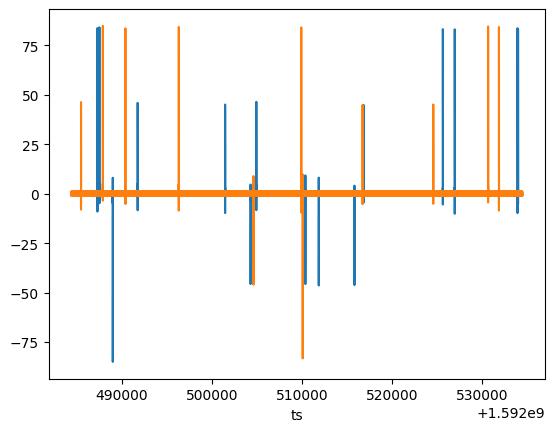

In [3]:
train_data['sensor_1'].plot()
test_data['sensor_1'].plot()

# Motor vibration acquisition error

## Model setup (LSTM AutoEncodeur)

In [4]:
def LSTMAE(nb_entries, width, loss="MSE"):
        """
        Sets up the architecture that will be used for the autoencoder
    
            Parameters: 
        
                nb_entries: an integer representing the number of rows of the spectrograms images
                width: an integer representing the number of columns of the spectrograms images
        
            Returns:
                model: convolutional autoencoder
        """
        valid_shape = (width, nb_entries)
        model = Sequential()
        model.add(LSTM(64, activation='relu', input_shape=valid_shape, return_sequences=True))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(units=10,activation="relu", name="latent"))
        model.add(BatchNormalization())
        model.add(Dense(32, activation='relu'))
        model.add(LSTM(64, activation='sigmoid', return_sequences=True))
        model.add(TimeDistributed(Dense(nb_entries)))
        optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.01)
        model.compile(optimizer=optimizer, loss=loss)
        return model

## Data preprocessing

In [5]:
def build_rolling_data(data,window):
    rolling_data = np.lib.stride_tricks.as_strided(data, (len(data) - window + 1, window),(data.strides[0], data.strides[0]))
    rolling_data = tf.expand_dims(rolling_data,axis=-1)
    return rolling_data

In [6]:
WINDOW_SIZE = 30
scaler = MinMaxScaler() # instanciating a scaler 
# minmax scaler formula X_scaled = X-min(X) / max(X)-min(X)
# Scales data between 0 and 1
data_train = train_data['sensor_1'].values
data_test = test_data['sensor_1'].values
scaler.fit(data_train.reshape(-1,1))
normalized_train_data = scaler.transform(data_train.reshape(-1,1))
normalized_test_data = scaler.transform(data_test.reshape(-1,1))

In [7]:
# Build LSTM AutoEncoder for unidimentional time series
model = LSTMAE(1, WINDOW_SIZE)

In [8]:
rolling_normalized_data = build_rolling_data(normalized_train_data,WINDOW_SIZE)

In [9]:
start = time.time()
model.fit(rolling_normalized_data,rolling_normalized_data,epochs= 20, verbose = True, batch_size=128)
print(f"model trained in {(time.time()-start)/60} minutes")

Epoch 1/20
391/391 [==============================] - 10s 23ms/step - loss: 0.0031
Epoch 2/20
391/391 [==============================] - 9s 23ms/step - loss: 1.6159e-05
Epoch 3/20
391/391 [==============================] - 9s 23ms/step - loss: 3.6595e-05
Epoch 4/20
391/391 [==============================] - 9s 23ms/step - loss: 1.1021e-05
Epoch 5/20
391/391 [==============================] - 9s 23ms/step - loss: 1.8855e-06
Epoch 6/20
391/391 [==============================] - 9s 23ms/step - loss: 1.4492e-06
Epoch 7/20
391/391 [==============================] - 9s 22ms/step - loss: 1.4317e-06
Epoch 8/20
391/391 [==============================] - 9s 23ms/step - loss: 3.1807e-06
Epoch 9/20
391/391 [==============================] - 9s 23ms/step - loss: 2.1652e-05
Epoch 10/20
391/391 [==============================] - 9s 23ms/step - loss: 2.8840e-05
Epoch 11/20
391/391 [==============================] - 9s 23ms/step - loss: 2.6037e-05
Epoch 12/20
391/391 [==============================] - 

## Prediction 

In [10]:
def predict_anomalies(model,data, sigma):
    rolling_data = build_rolling_data(data,WINDOW_SIZE)
    predicted = model.predict(rolling_data)
    reconstruction_error = np.mean((rolling_data-predicted)**2, axis =1)
    # the threshold is the  average of reconstruction error + 3 std reconstruction error
    # The predicted anomalies are the points with a decision inferior to 0 <=> reconstruction error > threshold
    decision = -reconstruction_error + np.mean(reconstruction_error)+sigma*np.std(reconstruction_error)
    padding = [0]*(len(data)-len(decision)) # creating a padding for the decision list to match size of initial data
    return list(decision.flatten()) + padding


In [13]:
train_data['predict'] = predict_anomalies(model,normalized_test_data,1.5)
# the anomalies are the points with an initial predict value inferior to 0
train_data['predict'] = train_data['predict'].apply(lambda x : 25 if x < 0 else 0)

1562/1562 [==============================] - 7s 4ms/step


<Axes: xlabel='ts'>

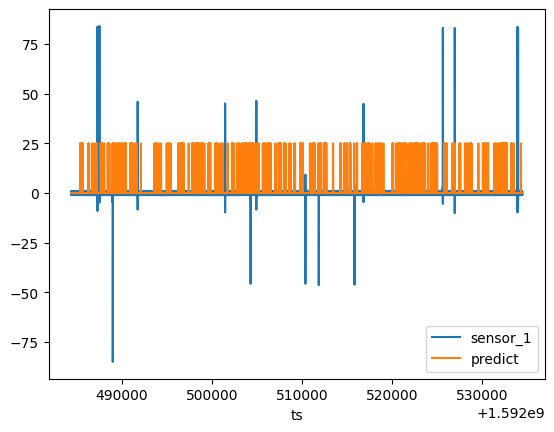

In [14]:
train_data[['sensor_1','predict']].plot()

In [15]:
test_data['predict']= predict_anomalies(model,normalized_test_data,1.5)
# the anomalies are the points with an initial predict value inferior to 0
# make the prediction visible by setting normal predicted values to zero and predicted anomalies to 25 ( for visibility in the visual validation ) 
test_data['predict'] = test_data['predict'].apply(lambda x : 25 if x < 0 else 0)

1562/1562 [==============================] - 7s 4ms/step


<Axes: xlabel='ts'>

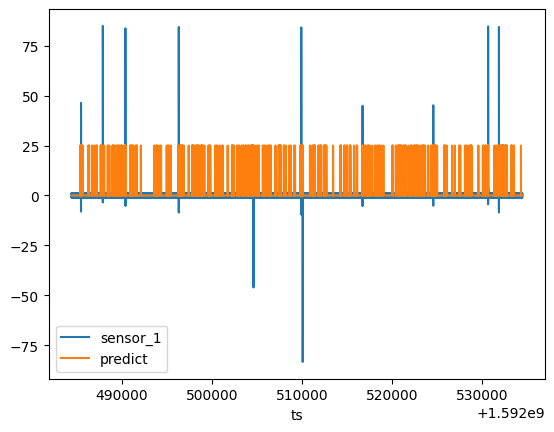

In [16]:
test_data[['sensor_1','predict']].plot()